# Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import  StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import silhouette_visualizer
from matplotlib import colors

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [2]:
df = pd.read_csv('/kaggle/input/marketing-campaign/marketing_campaign_data.csv')
df.head()

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,0,5524,1957,S1,Lajang,58138000.0,0,0,04-09-2012,58,635000,88000,546000,172000,88000,88000,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,1,2174,1954,S1,Lajang,46344000.0,1,1,08-03-2014,38,11000,1000,6000,2000,1000,6000,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,2,4141,1965,S1,Bertunangan,71613000.0,0,0,21-08-2013,26,426000,49000,127000,111000,21000,42000,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,3,6182,1984,S1,Bertunangan,26646000.0,1,0,10-02-2014,26,11000,4000,20000,10000,3000,5000,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,4,5324,1981,S3,Menikah,58293000.0,1,0,19-01-2014,94,173000,43000,118000,46000,27000,15000,5,5,3,6,5,0,0,0,0,0,0,3,11,0


# Feature Engineering

We can extract some new feature based on the existing feature in the following steps:
- **Age** can be extracted from `Year_Birth` column and can be segmented into several categories
- **Total Children** can be extracted from the sum of kids and teenager
- **isParent** can indicating parental status
- **Years Membership** indicating how long customer join membership
- **Total Accept Campaign** indicating the total campaign accepted by the customer
- **Total Spending** indicating the total spending amount of the customer
- **Total Transaction** indicating the total purchases of the customer
- **Conversion rate** can be extracted from total transaction divided total visit

In [3]:
# Age
df['Age'] = datetime.now().year - df['Year_Birth']

# Age segmentation
df['AgeSegmented'] = np.where(df['Age'] < 18, 'Teen',
                     np.where(df['Age'] < 25, 'Youth',
                     np.where(df['Age'] < 35, 'Young Adults',
                     np.where(df['Age'] < 50, 'Middle Aged',
                     np.where(df['Age'] < 65, 'Old Adults', 'Senior')))))

# TotalChildren and parental status
df['TotalChildren'] = df['Kidhome'] + df['Teenhome']
df['is_parents'] = np.where(df['TotalChildren'] > 0, 1, 0)

# convert Dt_customer to datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

# Years Membership
df['YearsMembership'] = datetime.now().year - df['Dt_Customer'].dt.year

# Total Accept Campaign
df['TotalAccCmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']

# Total Spending
df['TotalSpending'] = df['MntCoke'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

# TotalTransaction
df['TotalTransaction'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

# ConversionRate
def cr(trx, visit):
    if visit == 0:
        return 0
    return trx / visit

df['ConversionRate'] = df.apply(lambda x: cr(x['TotalTransaction'], x['NumWebVisitsMonth']), axis=1)

In [4]:
df['Marital_Status'].unique()

array(['Lajang', 'Bertunangan', 'Menikah', 'Cerai', 'Janda', 'Duda'],
      dtype=object)

In [5]:
df.head()

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,AgeSegmented,TotalChildren,is_parents,YearsMembership,TotalAccCmp,TotalSpending,TotalTransaction,ConversionRate
0,0,5524,1957,S1,Lajang,58138000.0,0,0,2012-04-09,58,635000,88000,546000,172000,88000,88000,3,8,10,4,7,0,0,0,0,0,0,3,11,1,66,Senior,0,0,11,0,1617000,25,3.571429
1,1,2174,1954,S1,Lajang,46344000.0,1,1,2014-08-03,38,11000,1000,6000,2000,1000,6000,2,1,1,2,5,0,0,0,0,0,0,3,11,0,69,Senior,2,1,9,0,27000,6,1.200000
2,2,4141,1965,S1,Bertunangan,71613000.0,0,0,2013-08-21,26,426000,49000,127000,111000,21000,42000,1,8,2,10,4,0,0,0,0,0,0,3,11,0,58,Old Adults,0,0,10,0,776000,21,5.250000
3,3,6182,1984,S1,Bertunangan,26646000.0,1,0,2014-10-02,26,11000,4000,20000,10000,3000,5000,2,2,0,4,6,0,0,0,0,0,0,3,11,0,39,Middle Aged,1,1,9,0,53000,8,1.333333
4,4,5324,1981,S3,Menikah,58293000.0,1,0,2014-01-19,94,173000,43000,118000,46000,27000,15000,5,5,3,6,5,0,0,0,0,0,0,3,11,0,42,Middle Aged,1,1,9,0,422000,19,3.800000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Unnamed: 0           2240 non-null   int64         
 1   ID                   2240 non-null   int64         
 2   Year_Birth           2240 non-null   int64         
 3   Education            2240 non-null   object        
 4   Marital_Status       2240 non-null   object        
 5   Income               2216 non-null   float64       
 6   Kidhome              2240 non-null   int64         
 7   Teenhome             2240 non-null   int64         
 8   Dt_Customer          2240 non-null   datetime64[ns]
 9   Recency              2240 non-null   int64         
 10  MntCoke              2240 non-null   int64         
 11  MntFruits            2240 non-null   int64         
 12  MntMeatProducts      2240 non-null   int64         
 13  MntFishProducts      2240 non-nul

# Data Exploratory

In [7]:
categorical = df.select_dtypes(include='object').columns.to_list()
numerical = df.select_dtypes(exclude=['object','datetime'],).columns.to_list()
numerical.remove('ID')

In [8]:
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,2240.0,1.119500e+03,6.467766e+02,0.0,5.597500e+02,1119.5,1679.25,2239.0
Year_Birth,2240.0,1.968806e+03,1.198407e+01,1893.0,1.959000e+03,1970.0,1977.00,1996.0
Income,2216.0,5.224725e+07,2.517308e+07,1730000.0,3.530300e+07,51381500.0,68522000.00,666666000.0
Kidhome,2240.0,4.441964e-01,5.383981e-01,0.0,0.000000e+00,0.0,1.00,2.0
Teenhome,2240.0,5.062500e-01,5.445382e-01,0.0,0.000000e+00,0.0,1.00,2.0
Recency,2240.0,4.910938e+01,2.896245e+01,0.0,2.400000e+01,49.0,74.00,99.0
MntCoke,2240.0,3.039357e+05,3.365974e+05,0.0,2.375000e+04,173500.0,504250.00,1493000.0
MntFruits,2240.0,2.630223e+04,3.977343e+04,0.0,1.000000e+03,8000.0,33000.00,199000.0
MntMeatProducts,2240.0,1.669500e+05,2.257154e+05,0.0,1.600000e+04,67000.0,232000.00,1725000.0
MntFishProducts,2240.0,3.752545e+04,5.462898e+04,0.0,3.000000e+03,12000.0,50000.00,259000.0


In [9]:
df[categorical].describe().T

,count,unique,top,freq
Education,2240,5,S1,1127
Marital_Status,2240,6,Menikah,864
AgeSegmented,2240,4,Old Adults,874


## Univariate Analysis

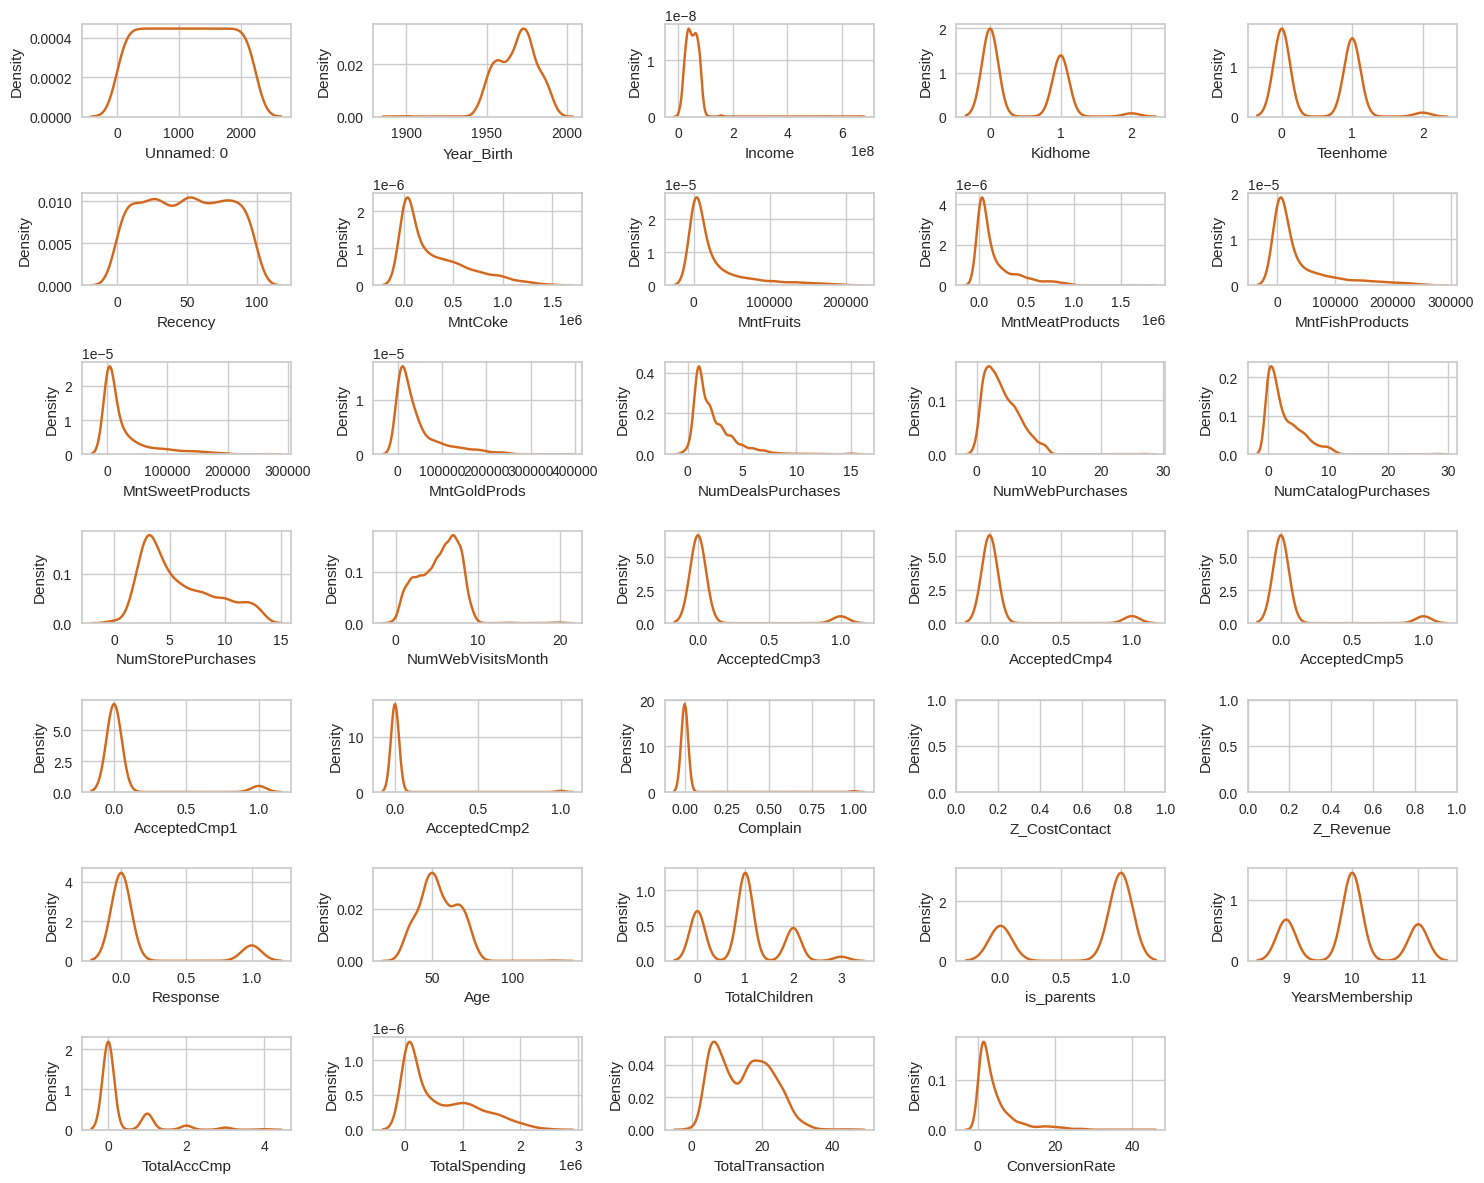

In [10]:
plt.figure(figsize=(15,12))
for i in range(0, len(numerical)):
    plt.subplot(7,5,i+1)
    sns.kdeplot(x=df[numerical[i]], color='chocolate')
    plt.tight_layout()

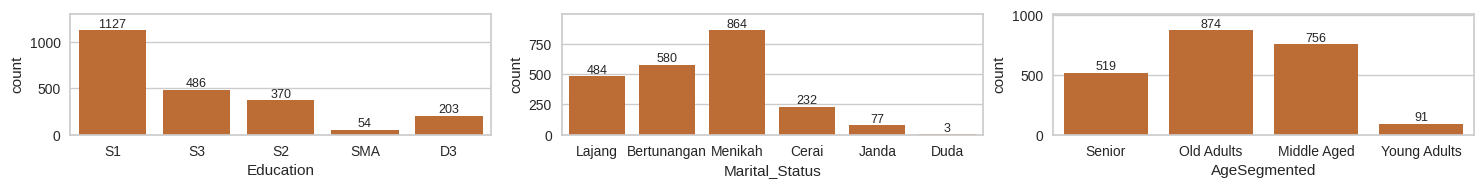

In [11]:
plt.figure(figsize=(15,2))
for i in range(0, len(categorical)):
    plt.subplot(1, 3, i+1)
    ax = sns.countplot(x=df[categorical[i]], color='chocolate')
    plt.tight_layout()
    for container in ax.containers:
        ax.bar_label(container, fontsize=9, fmt='%.f')
        ax.set_ylim(top = ax.get_ylim()[1]*1.1)

<Axes: xlabel='Dt_Customer,Dt_Customer'>

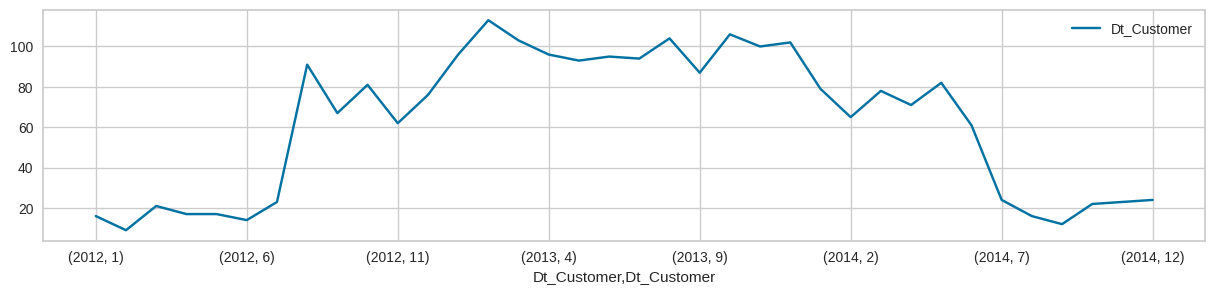

In [12]:
# fig, ax = plt.subplots(figsize=(10, 5))
df[['Dt_Customer']].groupby([df['Dt_Customer'].dt.year, df['Dt_Customer'].dt.month]).count().plot(kind='line', figsize=(15, 3))
# plt.show()

## Multivariate Analysis

<Axes: >

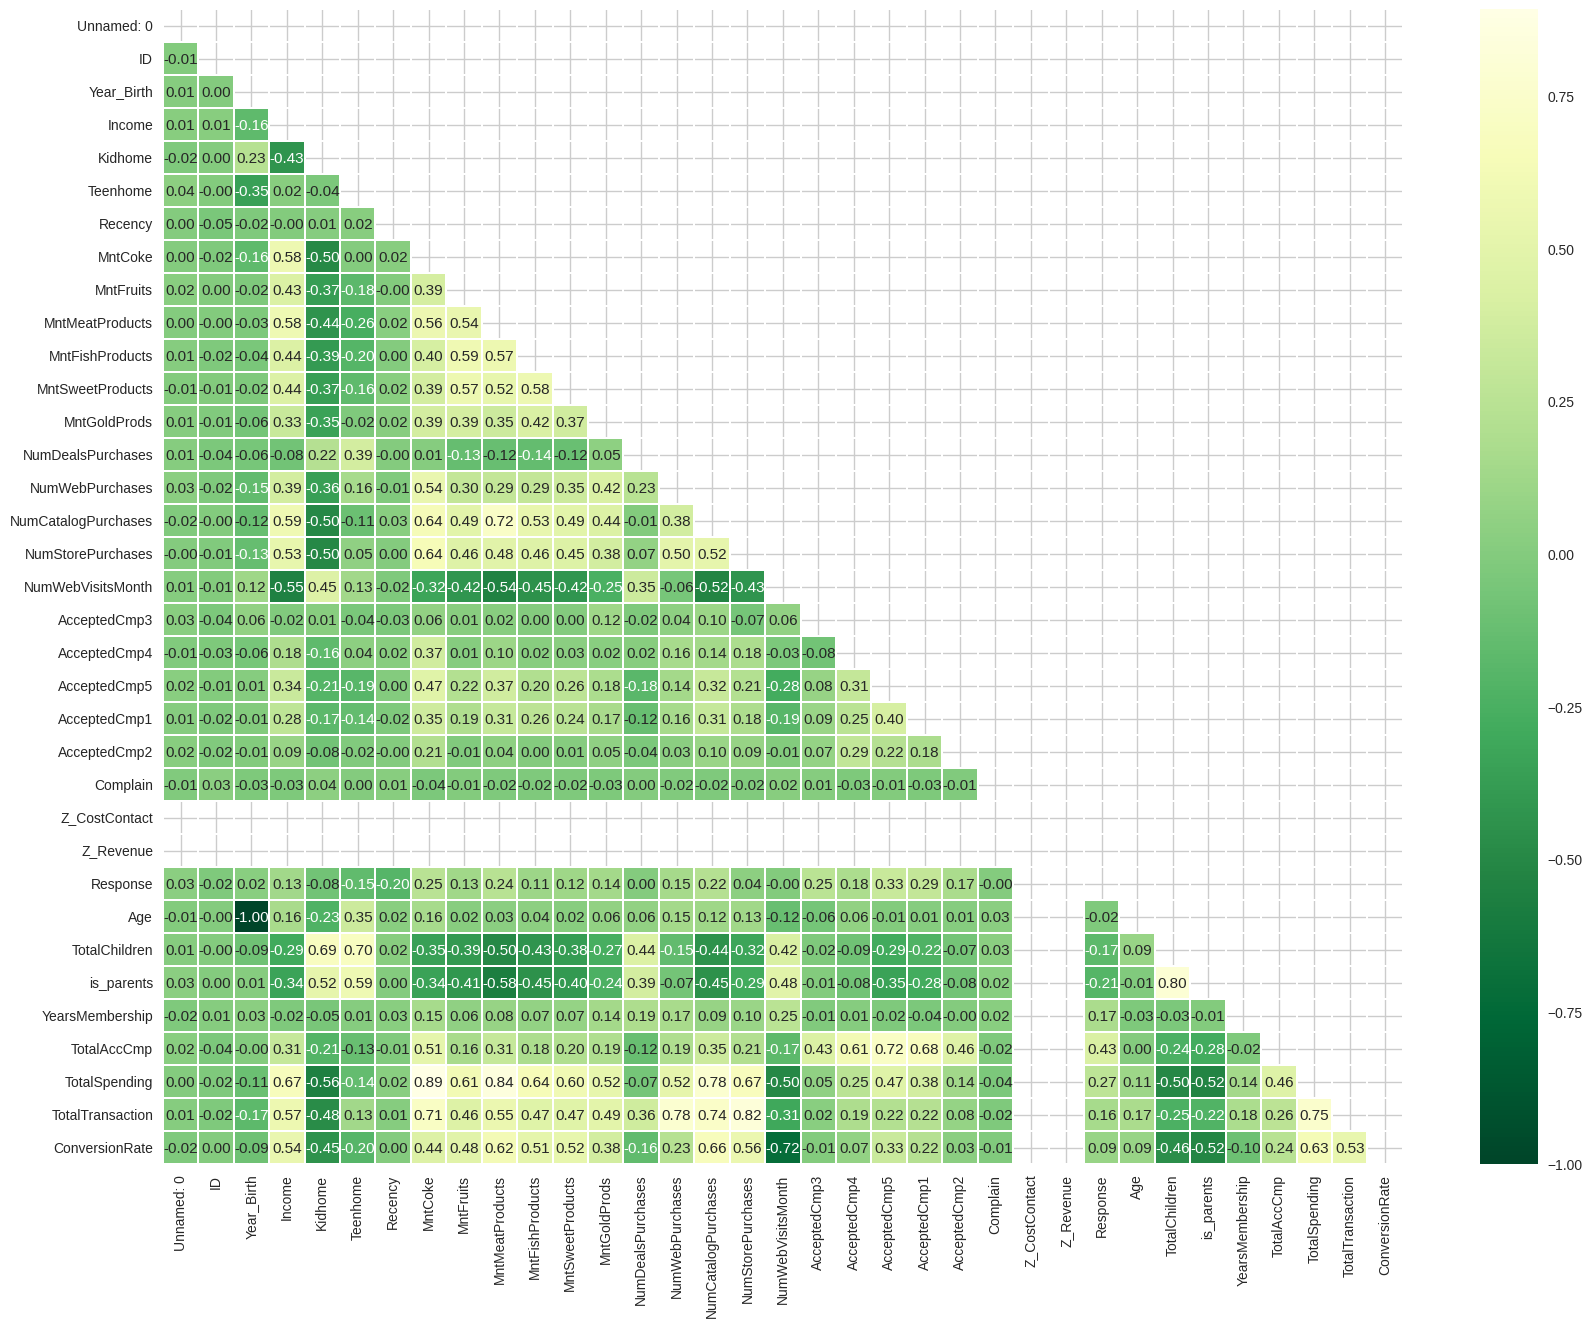

In [13]:
plt.figure(figsize=(20,15))
mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(df.corr(), mask=mask, annot=True, fmt='.2f', cmap='YlGn_r', linewidths=0.1,annot_kws={"fontsize":11})

**Insights:**
- `Age` column is identic with `Year_Birth` column, so we will drop the `Year_Birth` column.
- `Z_CostContact` and `Z_Revenue` have no correlation with any others columns, so we will drop these columns.
- We can identify the type of user that have a higher potential to respond to the campaign by looking at the correlation between `ConversionRate` and other columns. 
    - `NumWebVisitsMonth` has a high negative correlation and `TotalTransaction` has high positive correlation because `ConversionRate` comes from both columns.
    - `Income` has high positive correlation with 0.54 indicates that customer with higher income is more potential to respond to the campaign
    - `TotalSpending` has high positive correlation with 0.63 indicates that customer with higher total spending is more potential to respond to the campaign
    - `TotalChildren` has a high negative correlation with -0.46 indicates that fewer children customers have more potential to respond to the campaign

Let's take a look broader the correlation between `ConversionRate` with other selected features

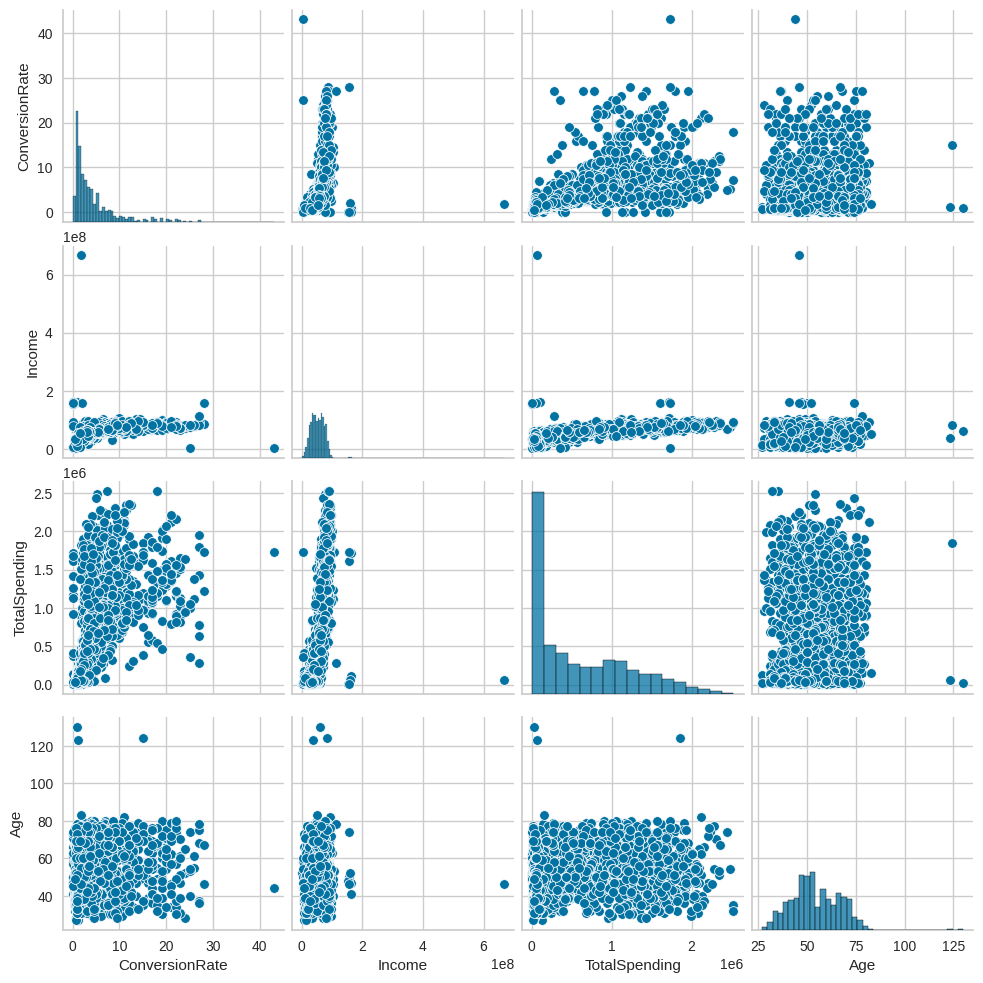

In [14]:
g = sns.pairplot(data=df[['ConversionRate', 'Income', 'TotalSpending', 'Age']]);

We see there are few outliers in `Age` and `Income` columns. I decided to remove the outliers

## Revenue Stream

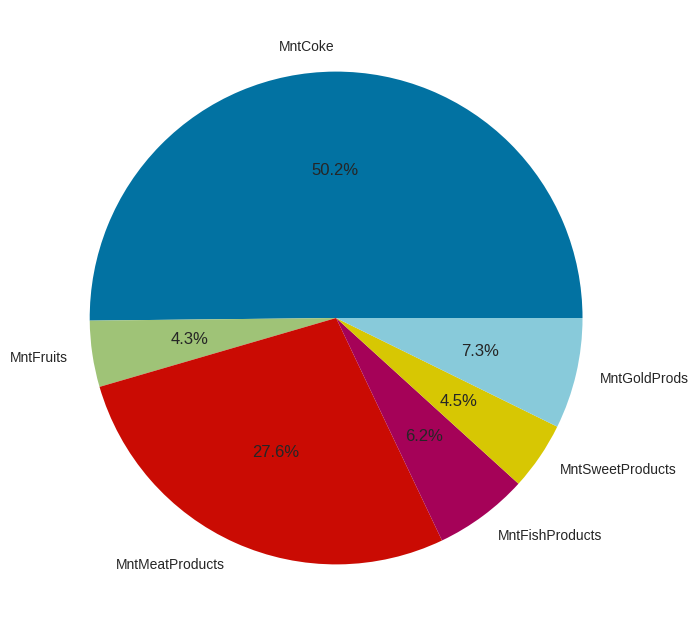

In [15]:
spent = df[['MntCoke', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum().reset_index()
spent.columns = ['category', 'total']
spent['percentage'] = round(spent['total'] / spent['total'].sum() * 100,2)

plt.figure(figsize=(10,8))
plt.pie(spent['percentage'],labels=spent['category'],autopct='%.1f%%' );

**Insight:** More than 50% of the company revenue comes from Coke product while Fruits and Sweet products have the lowest revenue. We can focus on these two lowest products for the next campaign, so we can gain more revenue from these products.

## Impact of having children on the total spending in each age segmentation

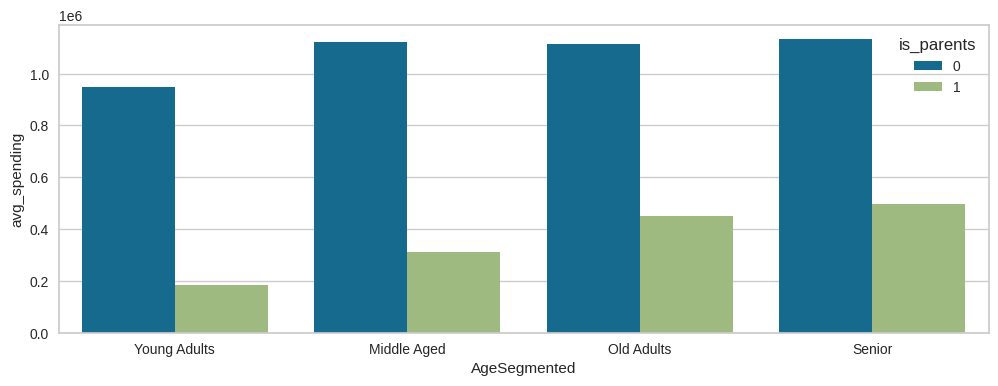

In [16]:
child = df[['AgeSegmented', 'is_parents', 'TotalSpending']]
# child['Children'] = np.where(child['TotalChildren'] > 0, 1, 0)
child = child.groupby(['AgeSegmented', 'is_parents'])['TotalSpending'].mean().reset_index(name='avg_spending')

order = ['Young Adults', 'Middle Aged', 'Old Adults', 'Senior']
mapping = {Segment: i for i, Segment in enumerate(order)}
key = child['AgeSegmented'].map(mapping)
child = child.iloc[key.argsort()]

plt.figure(figsize=(12,4))
sns.barplot(data=child, x='AgeSegmented', y='avg_spending', hue='is_parents');

**Insight:** Customers who have no children will spend more than those who have children, and the young adults customers have the lowest spending than other age categories. We can focus on targeting young adults customer to spend more on our products.

## Customer Purchase Method

<Axes: xlabel='total', ylabel='method'>

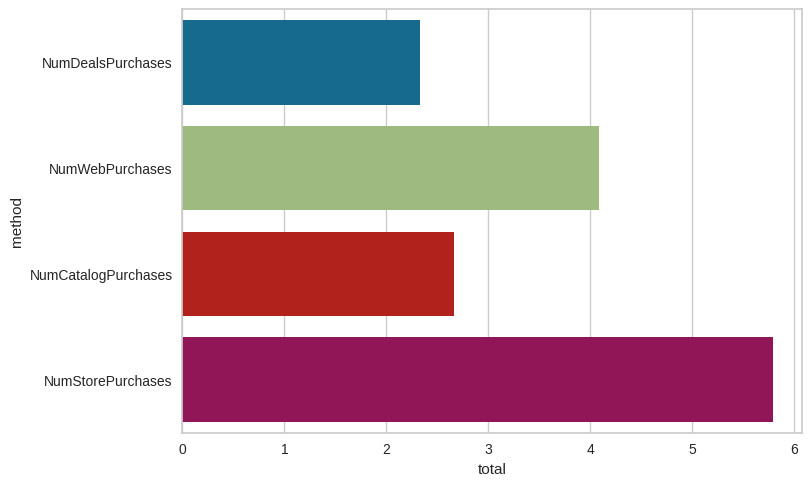

In [17]:
purchase = df[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].mean().reset_index()
purchase.columns = ['method', 'total']

sns.barplot(data=purchase, x='total', y='method', orient='h')

**Insight:** Most customers made purchases directly in the store, with an average of more than 5 times purchases made by each customer. It is probably because the customer can ensure the product before purchasing it. Meanwhile purchase made with discount and catalogue become the lowest method.

# Data Cleaning

**Duplicate Values**

In [18]:
df.duplicated().sum()

0

**Null Values**

In [19]:
df.isnull().mean()

Unnamed: 0             0.000000
ID                     0.000000
Year_Birth             0.000000
Education              0.000000
Marital_Status         0.000000
Income                 0.010714
Kidhome                0.000000
Teenhome               0.000000
Dt_Customer            0.000000
Recency                0.000000
MntCoke                0.000000
MntFruits              0.000000
MntMeatProducts        0.000000
MntFishProducts        0.000000
MntSweetProducts       0.000000
MntGoldProds           0.000000
NumDealsPurchases      0.000000
NumWebPurchases        0.000000
NumCatalogPurchases    0.000000
NumStorePurchases      0.000000
NumWebVisitsMonth      0.000000
AcceptedCmp3           0.000000
AcceptedCmp4           0.000000
AcceptedCmp5           0.000000
AcceptedCmp1           0.000000
AcceptedCmp2           0.000000
Complain               0.000000
Z_CostContact          0.000000
Z_Revenue              0.000000
Response               0.000000
Age                    0.000000
AgeSegme

There is no duplicated values and there is only `Income` column that have a null values. I decided to drop the values because the amount of null values is only 1% from the total rows.

In [20]:
df.dropna(inplace = True)
df.isnull().mean()

Unnamed: 0             0.0
ID                     0.0
Year_Birth             0.0
Education              0.0
Marital_Status         0.0
Income                 0.0
Kidhome                0.0
Teenhome               0.0
Dt_Customer            0.0
Recency                0.0
MntCoke                0.0
MntFruits              0.0
MntMeatProducts        0.0
MntFishProducts        0.0
MntSweetProducts       0.0
MntGoldProds           0.0
NumDealsPurchases      0.0
NumWebPurchases        0.0
NumCatalogPurchases    0.0
NumStorePurchases      0.0
NumWebVisitsMonth      0.0
AcceptedCmp3           0.0
AcceptedCmp4           0.0
AcceptedCmp5           0.0
AcceptedCmp1           0.0
AcceptedCmp2           0.0
Complain               0.0
Z_CostContact          0.0
Z_Revenue              0.0
Response               0.0
Age                    0.0
AgeSegmented           0.0
TotalChildren          0.0
is_parents             0.0
YearsMembership        0.0
TotalAccCmp            0.0
TotalSpending          0.0
T

**Drop Unused Data**

In [21]:
# Remove Outliers
df = df[(df['Age']<90)]
df = df[(df['Income']<600000000)]

In [22]:
df.drop(['Unnamed: 0', 'ID', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

In [23]:
df[df['TotalTransaction']==0]

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,AgeSegmented,TotalChildren,is_parents,YearsMembership,TotalAccCmp,TotalSpending,TotalTransaction,ConversionRate
655,S1,Cerai,153924000.0,0,0,81,1000,1000,1000,1000,1000,1000,0,0,0,0,0,0,0,0,0,0,0,0,48,Middle Aged,0,0,9,0,6000,0,0.0
981,S1,Cerai,4861000.0,0,0,20,2000,1000,1000,1000,0,1000,0,0,0,0,14,0,0,0,0,0,0,0,58,Old Adults,0,0,9,0,6000,0,0.0
1524,S1,Lajang,3502000.0,1,0,56,2000,1000,1000,0,0,1000,0,0,0,0,14,0,0,0,0,0,0,0,50,Old Adults,1,1,10,0,5000,0,0.0
2132,S3,Menikah,156924000.0,0,0,85,2000,1000,2000,1000,1000,1000,0,0,0,0,0,0,0,0,0,0,0,0,74,Senior,0,0,10,0,8000,0,0.0


As shown above, we found some weird data where some rows have 0 value on `TotalTransaction` column but the value on `TotalSpending` column is not 0. We decided to drop the rows because there are only 4 rows that have that condition.

In [24]:
df = df[df['TotalTransaction'] > 0]

# Feature Encoding

In [25]:
df[categorical].columns

Index(['Education', 'Marital_Status', 'AgeSegmented'], dtype='object')

Some features are categorical, so we need to convert that into numerical features by using label encoding and one-hot encoding. Here are what we will do:
- Label encoding: `Education`
- One-hot encoding: `Marital_Status` and `Segment`


**Label Encoding**

In [26]:
df['Education'].unique()

array(['S1', 'S3', 'S2', 'SMA', 'D3'], dtype=object)

In [27]:
df['Education'] = df['Education'].replace(['SMA','D3','S1', 'S2', 'S3'], [0,1,2,3,4])

**One-hot Encoding**

In [28]:
df['Marital_Status'] = df['Marital_Status'].replace(['Duda','Janda'], ['Cerai', 'Cerai'])

In [29]:
df_ohe = pd.get_dummies(df, prefix_sep=': ')
df_ohe.head()

,Education,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,TotalChildren,is_parents,YearsMembership,TotalAccCmp,TotalSpending,TotalTransaction,ConversionRate,Marital_Status: Bertunangan,Marital_Status: Cerai,Marital_Status: Lajang,Marital_Status: Menikah,AgeSegmented: Middle Aged,AgeSegmented: Old Adults,AgeSegmented: Senior,AgeSegmented: Young Adults
0,2,58138000.0,0,0,58,635000,88000,546000,172000,88000,88000,3,8,10,4,7,0,0,0,0,0,0,1,66,0,0,11,0,1617000,25,3.571429,0,0,1,0,0,0,1,0
1,2,46344000.0,1,1,38,11000,1000,6000,2000,1000,6000,2,1,1,2,5,0,0,0,0,0,0,0,69,2,1,9,0,27000,6,1.200000,0,0,1,0,0,0,1,0
2,2,71613000.0,0,0,26,426000,49000,127000,111000,21000,42000,1,8,2,10,4,0,0,0,0,0,0,0,58,0,0,10,0,776000,21,5.250000,1,0,0,0,0,1,0,0
3,2,26646000.0,1,0,26,11000,4000,20000,10000,3000,5000,2,2,0,4,6,0,0,0,0,0,0,0,39,1,1,9,0,53000,8,1.333333,1,0,0,0,1,0,0,0
4,4,58293000.0,1,0,94,173000,43000,118000,46000,27000,15000,5,5,3,6,5,0,0,0,0,0,0,0,42,1,1,9,0,422000,19,3.800000,0,0,0,1,1,0,0,0


# Feature Transformation

There some features that have a skewed and wide distribution, so we need to do some standardization to the following feartures:

`Income`, `Kidhome`, `Teenhome`, `MntCoke`, `MntFruits`, `MntMeatProducts`, `MntFishProducts`, `MntSweetProducts`, `MntGoldProds`, `NumDealsPurchases`, `NumWebPurchases`, `NumCatalogPurchases`, `NumStorePurchases`, `NumWebVisitsMonth`, `TotalChildren`, `TotalAccCmp`, `TotalSpending`, `TotalTransaction`, `ConversionRate`

In [30]:
column = ['Income', 'Kidhome', 'Teenhome','Recency', 'MntCoke', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 
          'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Age', 'TotalChildren', 
          'TotalAccCmp', 'TotalSpending', 'TotalTransaction', 'ConversionRate']
df_std = df_ohe.copy()
for col in column:
    df_std[col] = StandardScaler().fit_transform(df_std[[col]])

df_std.head()

,Education,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,TotalChildren,is_parents,YearsMembership,TotalAccCmp,TotalSpending,TotalTransaction,ConversionRate,Marital_Status: Bertunangan,Marital_Status: Cerai,Marital_Status: Lajang,Marital_Status: Menikah,AgeSegmented: Middle Aged,AgeSegmented: Old Adults,AgeSegmented: Senior,AgeSegmented: Young Adults
0,2,0.292925,-0.823235,-0.931270,0.311060,0.975863,1.550053,1.688262,2.451041,1.481762,0.850833,0.348987,1.425749,2.501580,-0.560167,0.698394,0,0,0,0,0,0,1,1.018743,-1.266516,0,11,-0.439634,1.674434,1.317746,-0.169164,0,0,1,0,0,0,1,0
1,2,-0.261644,1.039166,0.906303,-0.380080,-0.874099,-0.638273,-0.719275,-0.651903,-0.634855,-0.734941,-0.170961,-1.130379,-0.572908,-1.176741,-0.132230,0,0,0,0,0,0,0,1.275141,1.403143,1,9,-0.439634,-0.965102,-1.165726,-0.654469,0,0,1,0,0,0,1,0
2,2,0.926537,-0.823235,-0.931270,-0.794765,0.356244,0.569079,-0.179808,1.337632,-0.148276,-0.038747,-0.690910,1.425749,-0.231298,1.289556,-0.547542,0,0,0,0,0,0,0,0.335013,-1.266516,0,10,-0.439634,0.278302,0.794910,0.174350,1,0,0,0,0,1,0,0
3,2,-1.187869,1.039166,-0.931270,-0.794765,-0.874099,-0.562814,-0.656857,-0.505882,-0.586197,-0.754280,-0.170961,-0.765218,-0.914518,-0.560167,0.283082,0,0,0,0,0,0,0,-1.288844,0.068313,1,9,-0.439634,-0.921940,-0.904308,-0.627183,1,0,0,0,1,0,0,0
4,4,0.300213,1.039166,-0.931270,1.555113,-0.393821,0.418160,-0.219934,0.151212,-0.002303,-0.560893,1.388885,0.330266,0.110311,0.056408,-0.132230,0,0,0,0,0,0,0,-1.032445,0.068313,1,9,-0.439634,-0.309368,0.533492,-0.122388,0,0,0,1,1,0,0,0


# Dimensionnality Reduction

In [31]:
df_std.shape

(2208, 39)

We have lots of features for the final classification. The higher the number of features, the harder it is to work with it. So, we will be performing dimensionality reduction to reduce the complexity. One of the techniques that can be used for dimensionality reduction is Principal Component Analysis (PCA), where it reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss.

**Principal Component Analysis (PCA)**

In [32]:
pca = PCA(n_components=3, random_state=10)
df_pca = pd.DataFrame(pca.fit_transform(df_std), columns=['pca1', 'pca2', 'pca3'])
df_pca.describe()

,pca1,pca2,pca3
count,2.208000e+03,2.208000e+03,2.208000e+03
mean,1.158494e-16,-5.792468e-17,7.723291e-17
std,2.998614e+00,1.646328e+00,1.247164e+00
min,-5.253399e+00,-3.498323e+00,-3.613163e+00
25%,-2.806610e+00,-1.362713e+00,-8.496071e-01
50%,-6.952108e-01,-1.793343e-01,2.151457e-02
75%,2.586717e+00,1.177344e+00,7.983338e-01
max,7.882793e+00,5.877801e+00,5.053511e+00


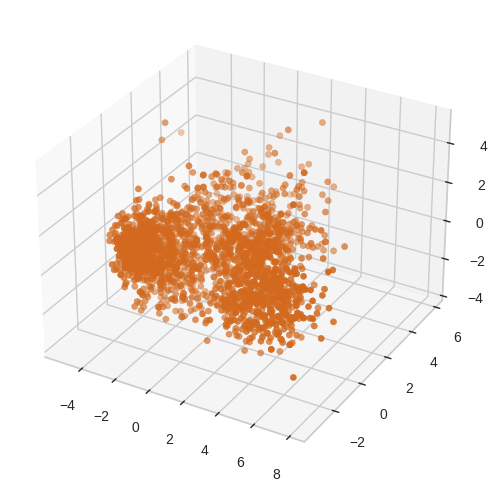

In [33]:
x = df_pca['pca1']
y = df_pca['pca2']
z = df_pca['pca3']

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection ='3d')
ax.scatter(x,y,z, c='chocolate')

# Clustering

We will classify the customer by creating a cluster with the following steps:
- Determine the number of the cluster using Elbow Method
- Clustering with KMeans
- Evaluate the performance using Silhouette Score


**Elbow Method**

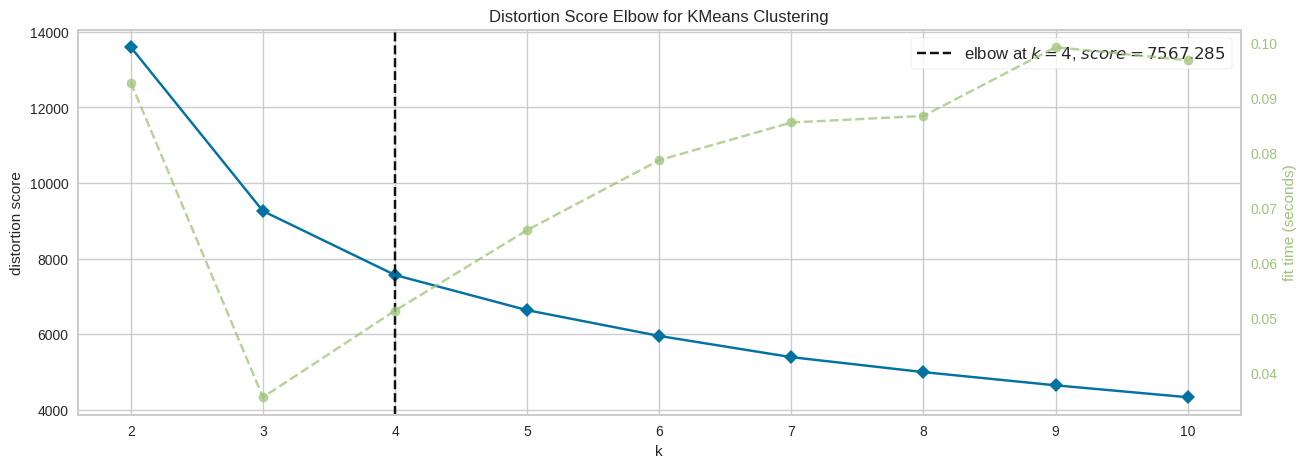

In [34]:
X = df_pca.copy()
plt.figure(figsize=(15, 5))
elbow = KElbowVisualizer(KMeans(), random_state=10)
elbow.fit(X)
elbow.show();

The graph shows that 4 is the optimal number of cluster. Next, we will create 4 clusters using KMeans.

**K-Means Clustering**

In [35]:
kmeans = KMeans(n_clusters=4, random_state=10)
cluster = kmeans.fit_predict(X.values)
X['Cluster'] = cluster
# df['Cluster'] = cluster

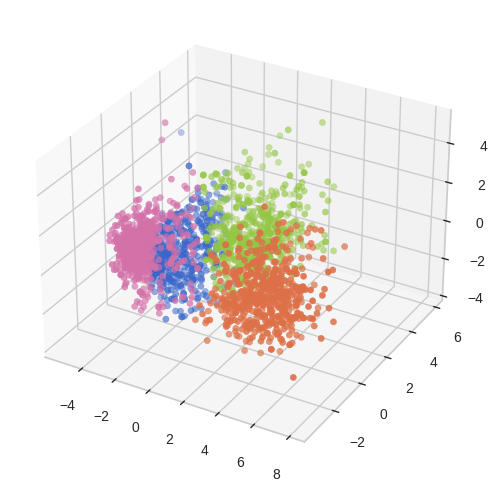

In [36]:
x = X['pca1']
y = X['pca2']
z = X['pca3']

pal = ['#94C743', '#D471A9', '#DE7048', '#3967CB']
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection ='3d')
ax.scatter(x,y,z, c=X['Cluster'], cmap=colors.ListedColormap(pal));

The clusters have been created. Now, we will evaluate the performance using silhouette score.

# Model Evaluation
We will use silhouette score to evaluate the model. There are several things determined the model is good:
- The closer the silhouette coefficients to 1 indicate that the sample is far from the neighboring clusters, which means the better model.
- Each cluster have the silhouette score equal to or more than the average silhouette score
- The size of each cluster should be as similar as possible

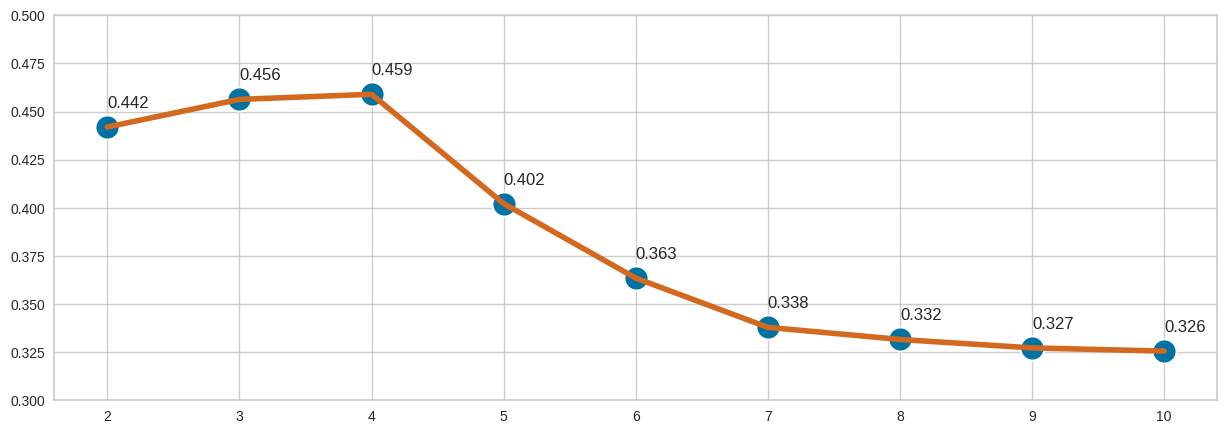

In [37]:
silhouette = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=10)
    clusters = kmeans.fit_predict(X)
    
    score = silhouette_score(X, clusters, random_state=10)
    silhouette.append(score)

plt.figure(figsize=(15, 5))
sns.lineplot(x=range(2, 11), y=silhouette, color='chocolate', linewidth = 4)
ax = sns.scatterplot(x=range(2, 11), y=silhouette, s=300)
ax.set_ylim(0.3,0.5)
for i in range(2,11):
    ax.annotate(text = round(silhouette[i-2],3), xy=(i, silhouette[i-2]+0.01))

For n_clusters = 4 The average silhouette_score is : 0.45895730533792545


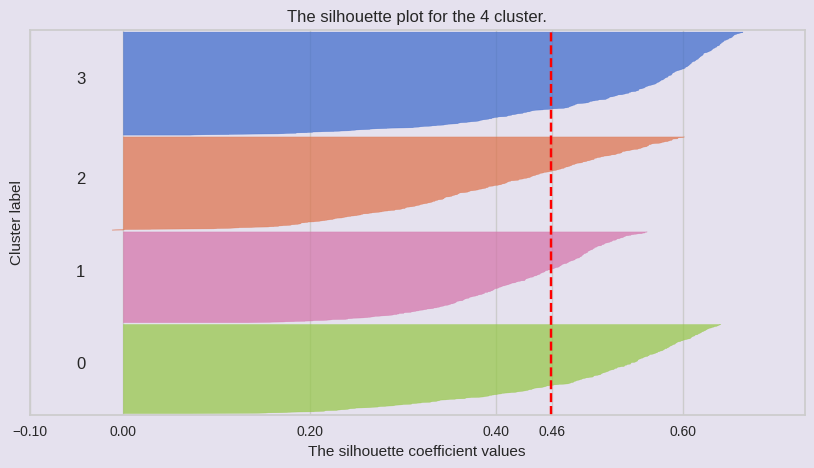

In [38]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
range_n_clusters = [4]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(figsize=(15,4), facecolor="#e5e1ee")
    fig.set_size_inches(10, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 0.73])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = pal[i]#cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the 4 cluster.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_facecolor("#e5e1ee")
#     ax1.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.46, 0.4, 0.6]);

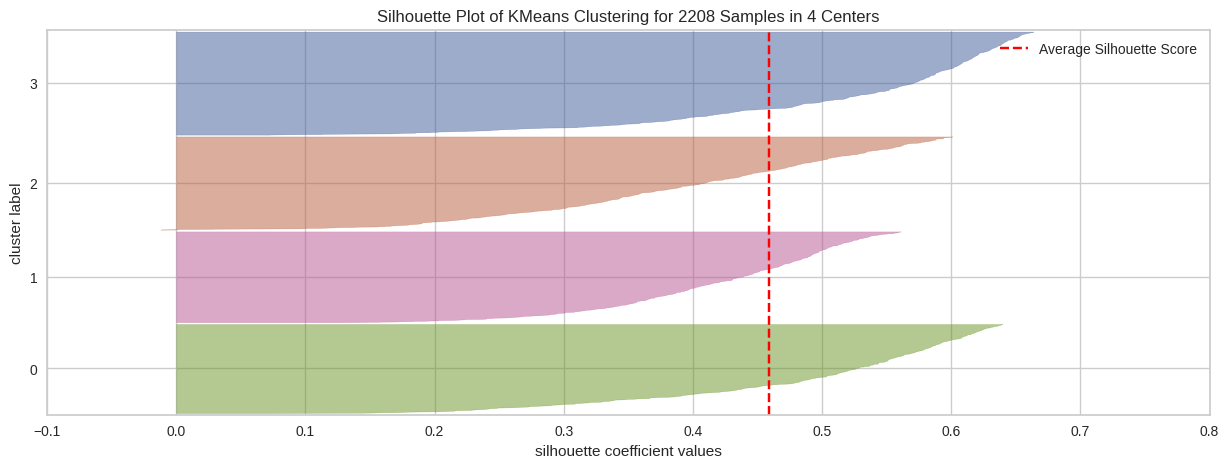

In [39]:
plt.figure(figsize=(15,5))
cmap = ['#699425', '#B95592', '#B95D3B', '#3F5B9A']
silhouette_visualizer(KMeans(4, random_state=10), X, colors=cmap);

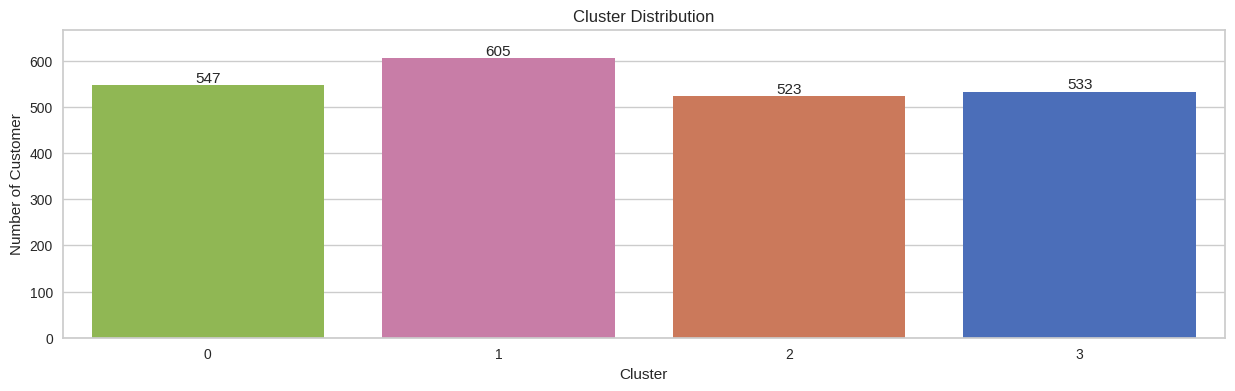

In [40]:
# pal = ['#a4cc64', '#db96c0', '#ec9474', '#95a3c3']

plt.figure(figsize=(15,4))
ax = sns.countplot(x=X['Cluster'], palette=pal)
plt.title('Cluster Distribution')
plt.ylabel('Number of Customer')
plt.xlabel('Cluster')
for container in ax.containers:
    ax.bar_label(container, fontsize=11, fmt='%.f')
    ax.set_ylim(top = ax.get_ylim()[1]*1.05)

From the graph we can find out several things:
- The average silhouette score is 0.46
- All the clusters are above the average silhouette score
- The cluster size are fairly distributed

We can conclude the model is good.


# Interprating Cluster
After labeling the cluster for each customer, we will do exploratory data to understand the pattern of each cluster so we know the profile of each group.

In [41]:
# assign cluster to the main dataset
df['Cluster'] = cluster 
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,AgeSegmented,TotalChildren,is_parents,YearsMembership,TotalAccCmp,TotalSpending,TotalTransaction,ConversionRate,Cluster
0,2,Lajang,58138000.0,0,0,58,635000,88000,546000,172000,88000,88000,3,8,10,4,7,0,0,0,0,0,0,1,66,Senior,0,0,11,0,1617000,25,3.571429,2
1,2,Lajang,46344000.0,1,1,38,11000,1000,6000,2000,1000,6000,2,1,1,2,5,0,0,0,0,0,0,0,69,Senior,2,1,9,0,27000,6,1.200000,3
2,2,Bertunangan,71613000.0,0,0,26,426000,49000,127000,111000,21000,42000,1,8,2,10,4,0,0,0,0,0,0,0,58,Old Adults,0,0,10,0,776000,21,5.250000,2
3,2,Bertunangan,26646000.0,1,0,26,11000,4000,20000,10000,3000,5000,2,2,0,4,6,0,0,0,0,0,0,0,39,Middle Aged,1,1,9,0,53000,8,1.333333,1
4,4,Menikah,58293000.0,1,0,94,173000,43000,118000,46000,27000,15000,5,5,3,6,5,0,0,0,0,0,0,0,42,Middle Aged,1,1,9,0,422000,19,3.800000,0


## Average Spending

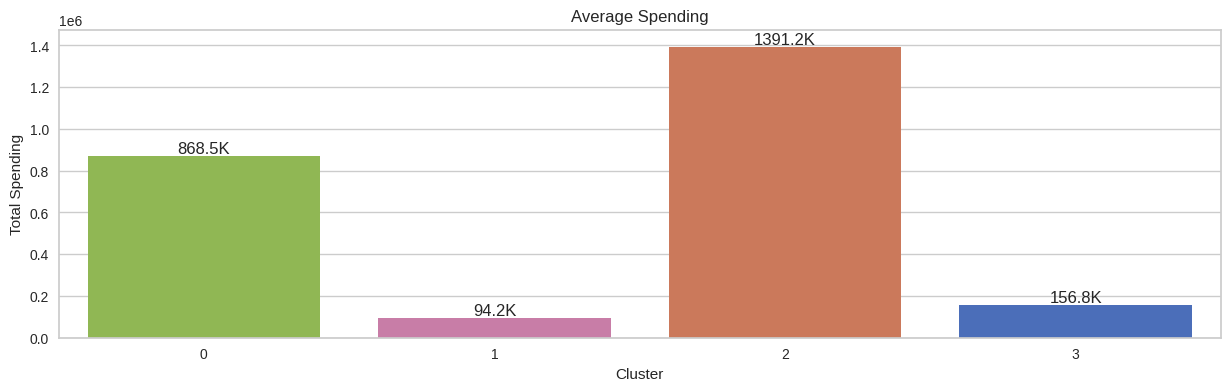

In [42]:
spent = df[['TotalSpending', 'Cluster']]
spent = spent.groupby('Cluster')['TotalSpending'].mean().reset_index()

plt.figure(figsize=(15,4))
ax = sns.barplot(data=spent, x='Cluster', y='TotalSpending', palette=pal)
plt.title('Average Spending')
plt.ylabel('Total Spending')
plt.xlabel('Cluster')
for container in ax.containers:
    ax.bar_label(container, fontsize=12, fmt='%.1f', labels=[f'{value/1000:.1f}K' for value in container.datavalues])
    ax.set_ylim(top = ax.get_ylim()[1]*1.01)

It shows cluster 2 have the highest average spending, followed by cluster 0. Next, we will look deeper into the distribution of each customer purchase category.

## Purchase Category

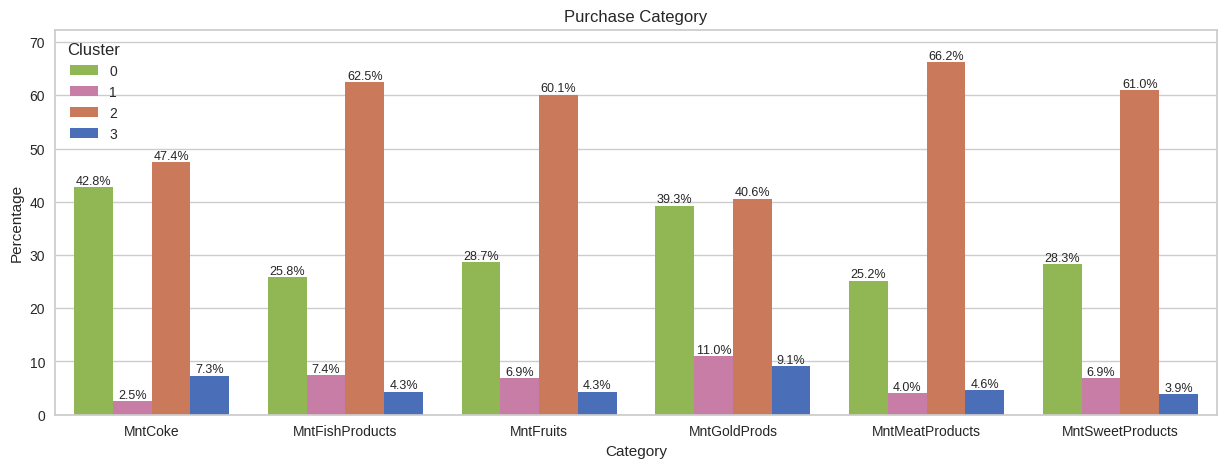

In [43]:
spent = df[['MntCoke', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Cluster']]
spent = spent.melt(id_vars=['Cluster'], value_vars=['MntCoke', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds'])
spent = spent.groupby(['variable', 'Cluster'])['value'].sum().reset_index()
spent = spent.pivot_table(values='value', index='variable', columns='Cluster').reset_index()

# count percentage of each cluster
total = spent[0] + spent[1] + spent[2] + spent[3]
spent['pct0'] = round(spent[0] / total * 100,1)
spent['pct1'] = round(spent[1] / total * 100,1)
spent['pct2'] = round(spent[2] / total * 100,1)
spent['pct3'] = round(spent[3] / total * 100,1)
spent = spent.melt(id_vars=['variable'], value_vars=['pct0', 'pct1', 'pct2', 'pct3'])
spent['Cluster'].replace(['pct0', 'pct1', 'pct2', 'pct3'], [0,1,2,3], inplace=True)

plt.figure(figsize=(15,5))
ax = sns.barplot(data=spent, x='variable', y='value', hue='Cluster', palette=pal)
plt.title('Purchase Category')
plt.ylabel('Percentage')
plt.xlabel('Category')
for container in ax.containers:
    ax.bar_label(container, fontsize=9, fmt='%.1f%%')
    ax.set_ylim(top = ax.get_ylim()[1]*1.01);

Cluster 2 almost dominates in all categories, followed by Cluster 0. It means that both groups give the highest contribution to the company's revenue. 

## Total Transaction

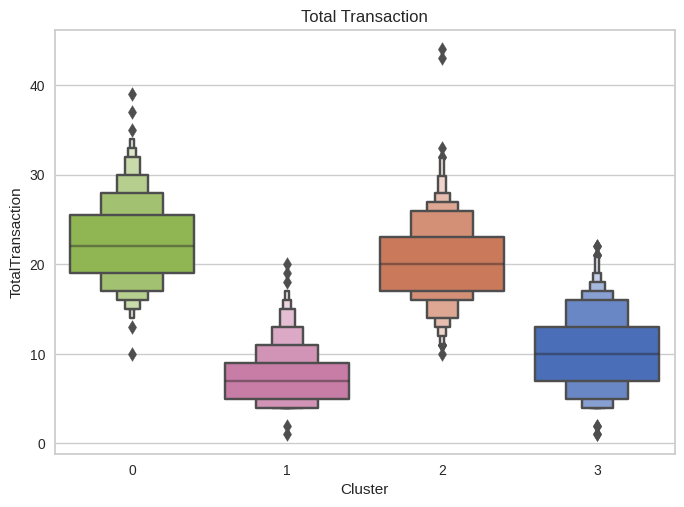

In [44]:
sns.boxenplot(data=df, x='Cluster', y='TotalTransaction', palette=pal)
plt.title('Total Transaction');

Cluster 0 and Cluster 2 dominate the total transaction. Next, we will check how is the distribution of each purchase method.

## Purchase Method

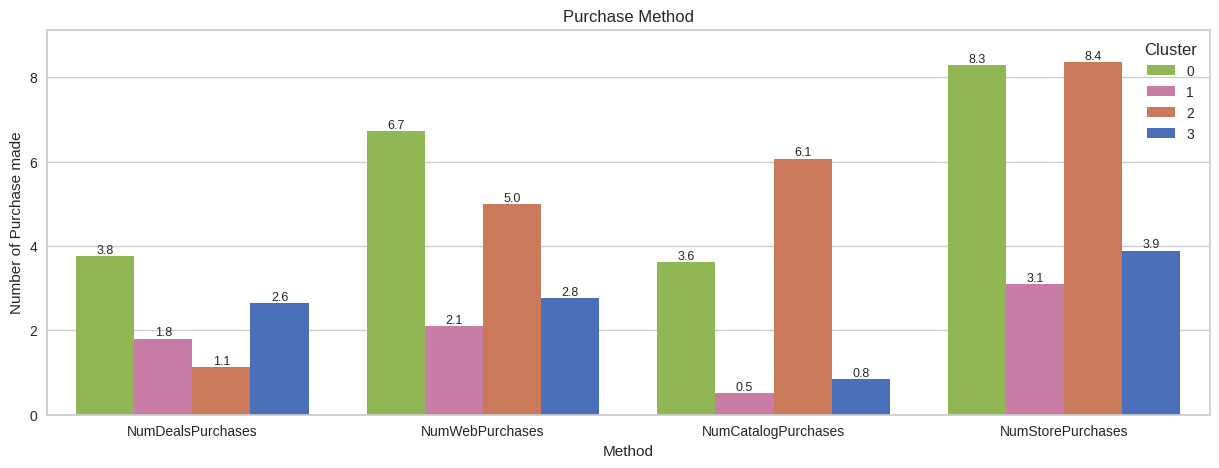

In [45]:
trx = df[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases','NumStorePurchases', 'Cluster']]
trx = trx.groupby('Cluster')['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases','NumStorePurchases'].mean().reset_index()
trx = trx.melt(id_vars=['Cluster'], value_vars=['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases','NumStorePurchases'])

plt.figure(figsize=(15,5))
ax = sns.barplot(data=trx, x='variable', y='value', hue='Cluster', palette=pal)
plt.title('Purchase Method')
plt.ylabel('Number of Purchase made')
plt.xlabel('Method')
for container in ax.containers:
    ax.bar_label(container, fontsize=9, fmt='%.1f')
    ax.set_ylim(top = ax.get_ylim()[1]*1.01)

It shows Cluster 2 mostly make purchase in the store and catalog but seldom use the coupons. Meanwhile, Cluster 0 mostly make purchase in the store and from the website and frequently use the coupon.

It shows Cluster 2 dominating the purchase made using Catalog, while the other purchase method is dominated by Cluster 0. However, there is a fascinating result on purchases made using Deals or Coupons, where Cluster 1 and 3 made up more than 20% of purchases through this method, which means that the Deals or Coupons attract more customers from these clusters to make purchases.

## Campaign Accepted

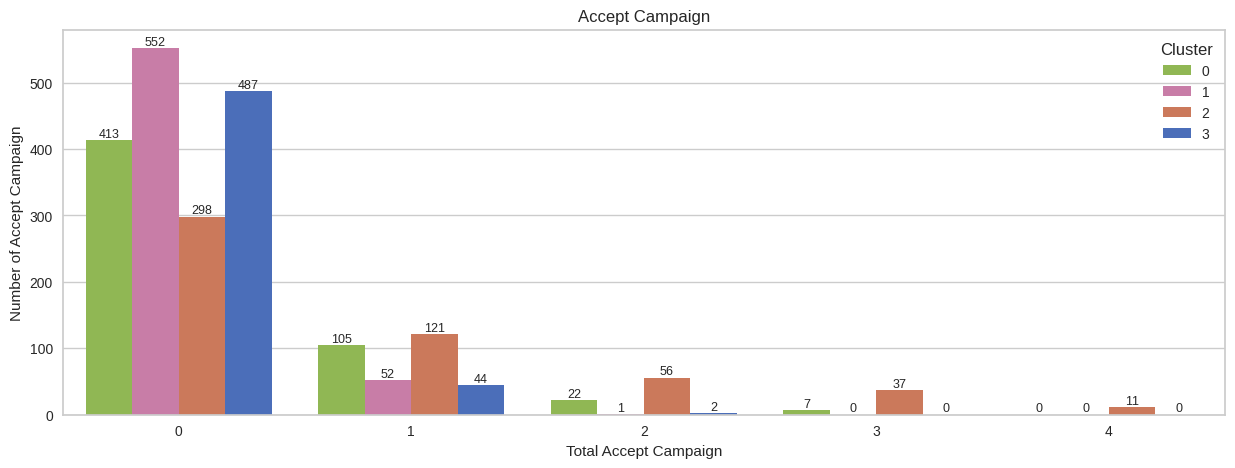

In [46]:
plt.figure(figsize=(15,5))
ax = sns.countplot(data=df, x='TotalAccCmp', hue='Cluster', palette=pal)
plt.title('Accept Campaign')
plt.ylabel('Number of Accept Campaign')
plt.xlabel('Total Accept Campaign')
for container in ax.containers:
    ax.bar_label(container, fontsize=9, fmt='%.f')

There is only few customer from Cluster 2 that accept all campaigns.


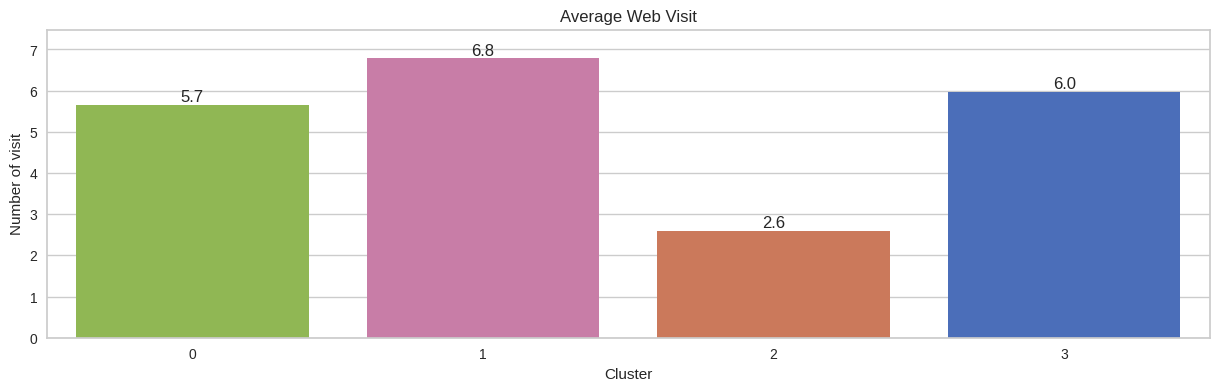

In [47]:
spent = df[['NumWebVisitsMonth', 'Cluster']]
spent = spent.groupby('Cluster')['NumWebVisitsMonth'].mean().reset_index()

plt.figure(figsize=(15,4))
ax = sns.barplot(data=spent, x='Cluster', y='NumWebVisitsMonth', palette=pal)
plt.title('Average Web Visit')
plt.ylabel('Number of visit')
plt.xlabel('Cluster')
for container in ax.containers:
    ax.bar_label(container, fontsize=12, fmt='%.1f')
    ax.set_ylim(top = ax.get_ylim()[1]*1.05)

Turns out, cluster 1 and 3 have the most visits to the website while cluster 2 seldom visit the website. Next, we will explore more features to make cluster profiling so we can understand the details of each cluster.

## Cluster Profiling

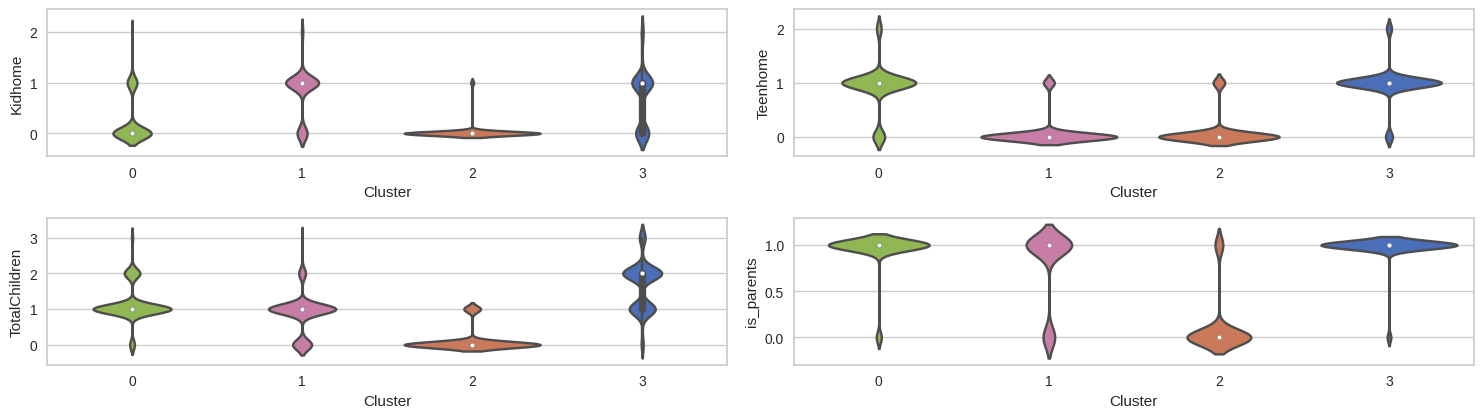

In [48]:
# select features to interprate the group
profile = ['Kidhome', 'Teenhome', 'TotalChildren', 'is_parents']
plt.figure(figsize=(15,6))
for i in range(0, len(profile)):
    plt.subplot(3, 2, i+1)
    sns.violinplot(data=df, x='Cluster', y=profile[i], palette=pal)
#     ax = sns.kdeplot(data=df, x=profile[i], y='TotalSpending', hue='Cluster', palette=pal)
plt.tight_layout()

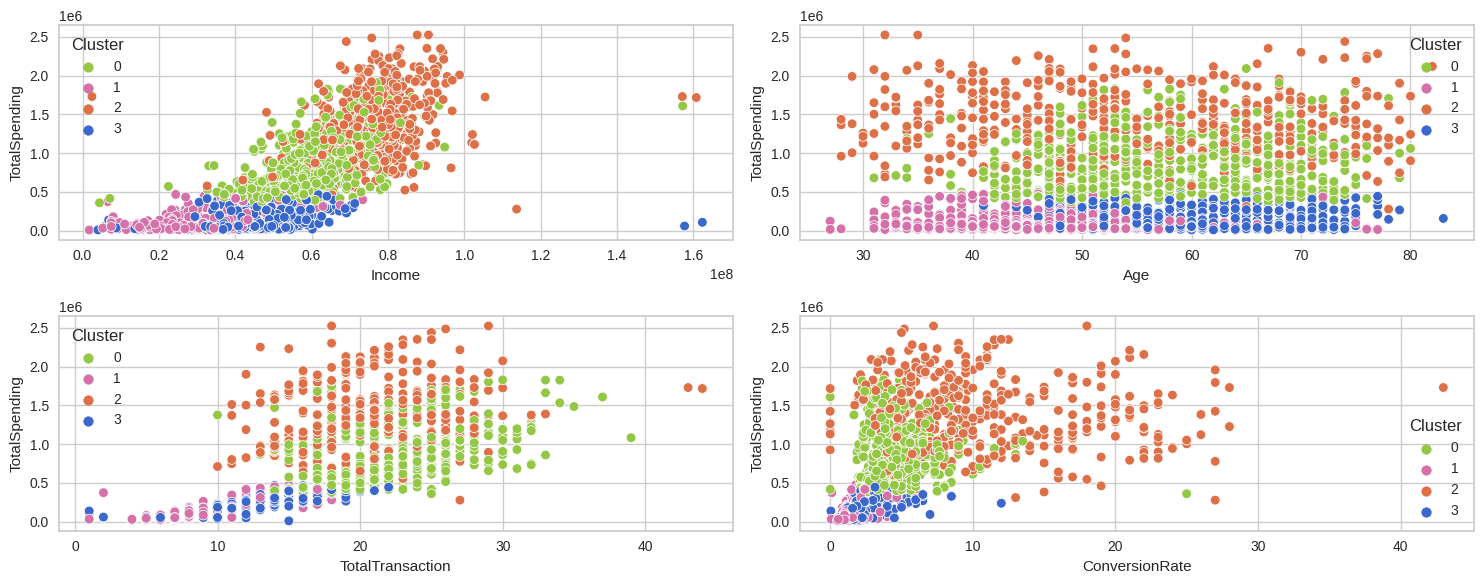

In [49]:
profile = ['Income', 'Age', 'TotalTransaction', 'ConversionRate']
plt.figure(figsize=(15,6))
for i in range(0, len(profile)):
    plt.subplot(2, 2, i+1)
    ax = sns.scatterplot(data=df, x=profile[i], y='TotalSpending', hue='Cluster', palette=pal)
plt.tight_layout()

# Cluster Profile

**Cluster 0 (Moderate Spender):**
- Dominated by customers aged 31 (Young Adults) to 80 years (Senior) 
- Most customers are parents with 1 - 2 children, with a slight majority of teenagers.
- Frequently visit the website with 5 visits per month
- Frequently make a purchase in the store and from the website with an average of 3 coupons used each month
- Have a moderate income of 30 to 80 million per year
- Have moderate spending with average spending of 867.7K

**Cluster 1 (Risk of Churn):**
- Have the highest number of customers than other groups, with 605 customers
- Dominated by customers aged 27 (Young Adults) to 60 years (Old Adults)
- Have 1 - 2 children, with a slight majority of kids
- Most frequently visited the website with almost 7 visits a month
- Quite often use coupons with almost 2 coupons used each month
- Have low income with less than 50 million per year
- Have low spending, with average spending of only 94.2K

**Cluster 2 (High Spender):**
- Have the lowest group with only 523 customers.
- Customers are spread in all age ranges.
- Most of the customers have no children.
- Frequently make a purchase in the store and from the catalog
- Least group that use coupon with only 1 coupon used each month
- Least visited the website with only 2 visits a month
- Have a high income with 50 to 100 million per year
- Have high spending with average spending of 1,39 million 

**Cluster 3 (Low Spender):**
- Dominated by customers aged 45 (Middle Aged) to 80 (Senior)
- Mostly a parent with 1 - 3 children, with a slight majority of teenagers
- Frequently make a purchase using coupons with more than 2 coupons used each month
- Frequently visit the website with 6 visits a month
- Have a moderate income of 30 to 70 million per year
- Have low spending with average spending of 156.2K

# Recommendation
Based on the customer group profile we can give the following recommendations:
1. Focus on improving service to retain the High Spender customers so they are satisfied with our services and have a pleasant experience.
2. Give a personalized recommendation to increase the transaction of Moderate Spender customers. Optimize coupons used for this group, as this group uses more coupons than other groups.
3. Needs further analysis to increase the conversion rate for Low Spender and Risk of Churn customers, as these groups frequently visit the website but have low transactions.